## Scientific work "Machine learning model features assesment"

We will examine data for problems as: 
- high percentge of missing feature values 
- single feature value
- low significance
- zero-significance in trees-based methods
- noisy markup
- changing of distribution density of features over time
- changing of distribution density of markup subject to features over time
- features correlation
- сovariance shift

FOR NOW WE WILL IMPLEMENT DATA ASSESMENT AS A LIBRARY, CONTAINING DIAGNOSTICS FUNCTIONS FOR EACH PROBLEM

## Научная работа "Анализ качества признаков для машинного обучения"

Будем анализировать данные на наличие следующих проблем: 
- высокий процент пропущенных значений
- единственное значение признака
- низкая важность
- нулевая важность в моделях, основанных на деревьях 
- шумная разметка
- изменение плотности распределения признаков во времени 
- изменение плотности разметки при условии признаков во времени
- коррелированность признаков 
- ковариационный сдвиг(в случае с тренировочной и тестовой выборкой) 

ПОКА РЕАЛИЗУЕМ ОЦЕНКУ ДАННЫХ КАК БИБЛИОТЕКУ С ФУНКЦИЯМИ ДИАГНОСТИКИ ДЛЯ КАЖДОЙ ПРОБЛЕМЫ

_______________________________________________________________________________________________________________

## Data loading

Insert path to csv-file, containing data to analyze, and the file's name in the path

In [3]:
path = '/home/valeriy/Рабочий стол/Codes/Research/home-credit-default-risk'
filename = 'application_train.csv'

In [4]:
import pandas as pd
from config import color

file_path = path + '/' + filename
main_table = pd.read_csv(file_path)

In [3]:
print(color['BOLD'] + color['GREEN'] + "WE HAVE THE FOLLOWING TABLE:\n" + color['END'])
main_table.head()

WE HAVE THE FOLLOWING TABLE:



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


_______________________________________________________________________________________________________________

## Summary of given data

In [5]:
from os import listdir
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import numpy as np

def get_summary():
    """
    Prints the sumary of given data
    """
    description_flag = 0

    #is there columns description filename
    for filename_from_dir in listdir(path):
        if 'columns_description' in filename_from_dir:
            description_flag = 1
            description_filename = path + '/' + filename_from_dir
            break

    print(color['BOLD'] + color['GREEN'] + "THE TABLE HAS THE FOLLOWING COLUMNS:\n" + color['END'])
    if description_flag:
        all_description = pd.read_csv(description_filename, encoding = "ISO-8859-1")
        #in table tablenames are bad  
        description = all_description.loc[all_description['Table'] == 'application_{train|test}.csv'] 
        for col in description['Row']:
            print(color['BOLD'] + col + color['END'], ' --- ', description.loc[description['Row'] == col]['Description'].to_string()[5:], '\n')
    else:
        for col in list(main_table):
            print(color['BOLD'] + col + color['END'])
        print(color['BOLD'] + color['RED'] + "\nTHE DESCPRIPTION FILE HAS NOT BEEN FOUND")
        print("\nPLEASE, ADD DESCRIPTION FILE WITH NAME *columns_direction.csv")
        print("\nAND COLUMNS [Table | Row | Description] TO THE WORKING DIRECTORY" + color['END'])

def get_distribution(X, title = 'Feature', nbins = 10, log = False):
    """
    Displays distributions graphics;
    arguments:
        X: array; array to display the distribution of;
    """
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.set_title(title)
    ax.set_ylabel('Frequence')
    ax.set_xlabel(title)
    if log:
        ax.hist(np.log10(X), bins = nbins, color = 'indigo', density = True)
    else: 
        ax.hist(X, bins = nbins, color = 'indigo', density = True)
    plt.show()

## Diagnostics of single feature values

In [5]:
def get_unique_values(out = False):
    """
    return: table with columns [feature | number of unique values]
    arguments: 
        out: boolean; if True, print table of unique values numbers;
             Default is False;
    """
    unique_values = main_table.nunique()
    unique_val_table = pd.DataFrame(unique_values).rename(columns = {'index': 'feature', 0: 'nunique'})
    unique_val_table = unique_val_table.sort_values('nunique', ascending = True)
    if out:
        print (color['BOLD'] + color['GREEN'] + 
               "----------------------------------------------\n" +      
               "Columns in the table have following numbers of\n" +
               "unique values: \n"
               "----------------------------------------------\n" +
               color['END'])
        print(unique_val_table, "\n")
    return unique_val_table

def get_single_value(out = False, delete = False):
    """
    return: list of features with single value
    arguments:
        out: boolean; if True print table of unique values numbers;
             Default is False;
        delete: boolean; if True delete all columns with single value;
             Default is False;
    """
    unique_val_table = get_unique_values(out = False)
    single_val_table = unique_val_table.loc[unique_val_table['nunique'] == 1]
    if out:
        print (color['BOLD'] + color['GREEN'] + 
               "----------------------------------------------\n" +      
               "There are " + str(single_val_table.shape[0]) +
               " columns that have single value\n" +
               "----------------------------------------------\n" +
               color['END'])
        print(single_val_table, "\n")
    del_list = single_val_table.index.to_list()
    if delete:
        delete_single_val()
    return del_list

def delete_single_val(del_features = []):
    """
    return: main_table with removed columns
    arguments:
        del_features: list; if empty remove all with single value,
                      else remove all from the list;
                      Default is empty list;
    """
    if len(del_features):
        dropping_columns = del_features
    else:
        dropping_columns = get_single_value()
    print(color['BOLD'] + color['GREEN'] + '%d columns were removed\n' % len(dropping_columns) + color['END'])
    main_table.drop(columns = dropping_columns, inplace = True)

## Diagnostics of missing features values


In [6]:
def get_missing(out = False, delete = False):
    """
    return: table with columns [feature | percenatge of missing values]
    arguments: 
        out: boolean; if True, print table of unique values numbers;
             Default is False;
        delete: boolean; if True delete all columns with percentage
             of missing values > default threshold;
             Default is False;
    """
    mis_val = main_table.isnull().sum()
    mis_val_percent = 100 * main_table.isnull().sum() / len(main_table)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    if out:
        print (color['BOLD'] + color['GREEN'] + 
               "----------------------------------------------\n" +     
               "There are " + str(mis_val_table_ren_columns.shape[0]) +
               " columns that have missing values\n" +
               "----------------------------------------------\n" +
               color['END'])

        print(mis_val_table_ren_columns,"\n")
    if delete:
        delete_missing()
    return mis_val_table_ren_columns

def delete_missing(del_threshold = 65.0, del_features = []):
    """
    Deletes columns with missing values
    arguments: 
        del_threshold: float; threshold for percentage of missing values:
                       delete if percentage > del_threshold;
                       Default is 65.0;
        del_features: list; if empty remove all columns
                      with percentage of missing values > del_threshold,
                      else remove all columns from the list;
                      Default is empty list; 
    """
    if len(del_features):
        dropping_columns = del_features
    else:
        missing_df = get_missing(out = False)
        dropping_columns = list(missing_df[missing_df['% of Total Values'] > del_threshold].index)
    print(color['BOLD'] + color['GREEN'] + '%d columns were removed\n' % len(dropping_columns) + color['END'])
    main_table.drop(columns = dropping_columns, inplace = True)

In [7]:
get_summary()

THE TABLE HAS THE FOLLOWING COLUMNS:

SK_ID_CURR  ---  ID of loan in our sample 

TARGET  ---  Target variable (1 - client with payment diffi... 

NAME_CONTRACT_TYPE  ---  Identification if loan is cash or revolving 

CODE_GENDER  ---  Gender of the client 

FLAG_OWN_CAR  ---  Flag if the client owns a car 

FLAG_OWN_REALTY  ---  Flag if client owns a house or flat 

CNT_CHILDREN  ---  Number of children the client has 

AMT_INCOME_TOTAL  ---  Income of the client 

AMT_CREDIT  ---  Credit amount of the loan 

AMT_ANNUITY  ---  Loan annuity 

AMT_GOODS_PRICE  ---   For consumer loans it is the price of the good... 

NAME_TYPE_SUITE  ---   Who was accompanying client when he was applyi... 

NAME_INCOME_TYPE  ---   Clients income type (businessman, working, mat... 

NAME_EDUCATION_TYPE  ---   Level of highest education the client achieved 

NAME_FAMILY_STATUS  ---   Family status of the client 

NAME_HOUSING_TYPE  ---   What is the housing situation of the client (r... 

REGION_POPULATIO

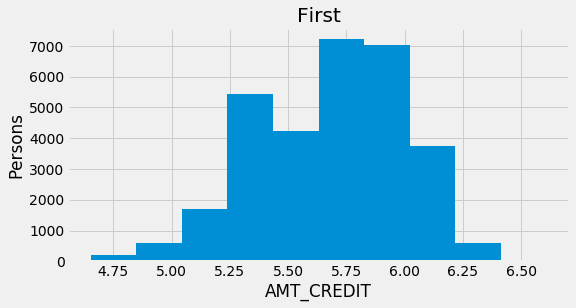

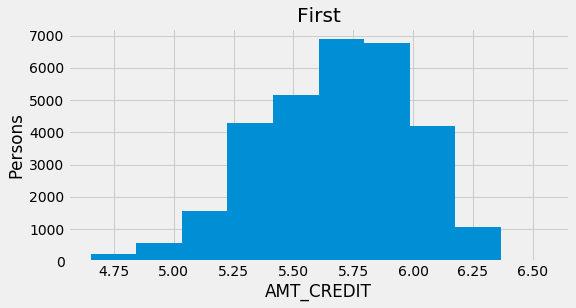

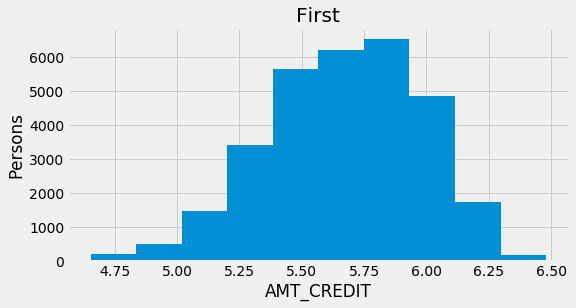

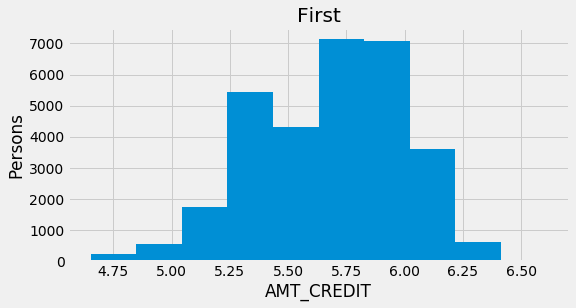

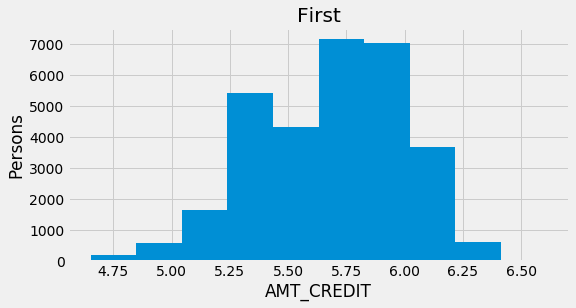

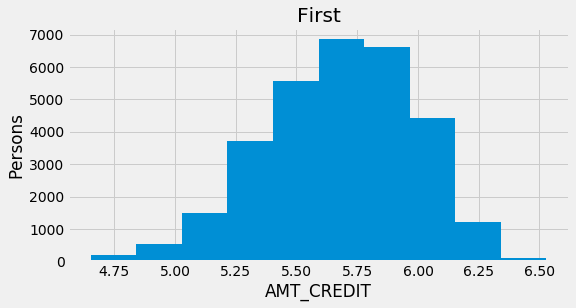

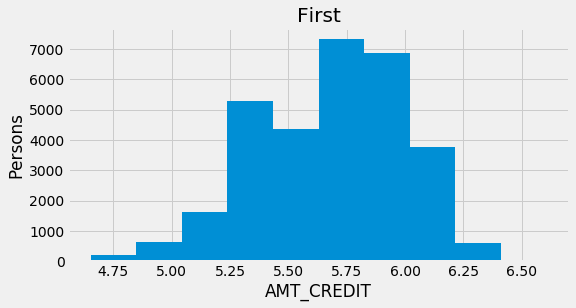

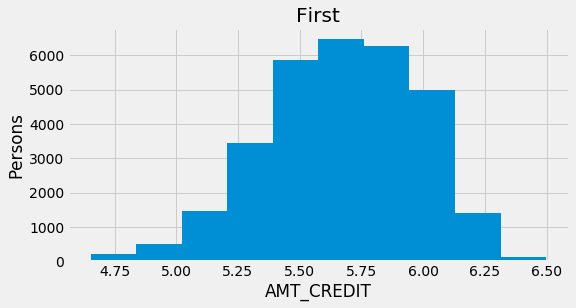

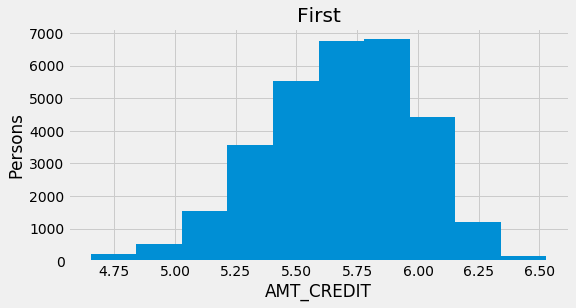

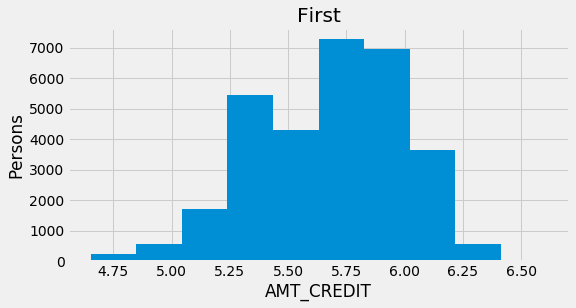

In [30]:
get_distribution()

In [9]:
unique_val_table = get_unique_values(out = True)

----------------------------------------------
Columns in the table have following numbers of
unique values: 
----------------------------------------------

                            nunique
LIVE_CITY_NOT_WORK_CITY           2
FLAG_DOCUMENT_18                  2
FLAG_DOCUMENT_14                  2
FLAG_MOBIL                        2
FLAG_EMP_PHONE                    2
FLAG_WORK_PHONE                   2
FLAG_CONT_MOBILE                  2
FLAG_PHONE                        2
FLAG_EMAIL                        2
FLAG_DOCUMENT_15                  2
FLAG_DOCUMENT_16                  2
FLAG_DOCUMENT_17                  2
EMERGENCYSTATE_MODE               2
REG_CITY_NOT_WORK_CITY            2
REG_CITY_NOT_LIVE_CITY            2
REG_REGION_NOT_LIVE_REGION        2
FLAG_DOCUMENT_19                  2
REG_REGION_NOT_WORK_REGION        2
FLAG_DOCUMENT_20                  2
FLAG_DOCUMENT_13                  2
TARGET                            2
NAME_CONTRACT_TYPE                2
FLAG_DOCUMENT_

In [10]:
single_val_list = get_single_value(out = True)

----------------------------------------------
There are 0 columns that have single value
----------------------------------------------

Empty DataFrame
Columns: [nunique]
Index: [] 



In [11]:
missing_df = get_missing(out = True)

----------------------------------------------
There are 67 columns that have missing values
----------------------------------------------

                              Missing Values  % of Total Values
COMMONAREA_MEDI                       214865               69.9
COMMONAREA_AVG                        214865               69.9
COMMONAREA_MODE                       214865               69.9
NONLIVINGAPARTMENTS_MEDI              213514               69.4
NONLIVINGAPARTMENTS_MODE              213514               69.4
NONLIVINGAPARTMENTS_AVG               213514               69.4
FONDKAPREMONT_MODE                    210295               68.4
LIVINGAPARTMENTS_MODE                 210199               68.4
LIVINGAPARTMENTS_MEDI                 210199               68.4
LIVINGAPARTMENTS_AVG                  210199               68.4
FLOORSMIN_MODE                        208642               67.8
FLOORSMIN_MEDI                        208642               67.8
FLOORSMIN_AVG              

In [12]:
delete_missing()

17 columns were removed



In [13]:
missing_df = get_missing(out = True)

----------------------------------------------
There are 50 columns that have missing values
----------------------------------------------

                              Missing Values  % of Total Values
LANDAREA_AVG                          182590               59.4
LANDAREA_MEDI                         182590               59.4
LANDAREA_MODE                         182590               59.4
BASEMENTAREA_MODE                     179943               58.5
BASEMENTAREA_AVG                      179943               58.5
BASEMENTAREA_MEDI                     179943               58.5
EXT_SOURCE_1                          173378               56.4
NONLIVINGAREA_MODE                    169682               55.2
NONLIVINGAREA_AVG                     169682               55.2
NONLIVINGAREA_MEDI                    169682               55.2
ELEVATORS_MEDI                        163891               53.3
ELEVATORS_AVG                         163891               53.3
ELEVATORS_MODE             

In [14]:
#Примеры для презентации
#big and small data
"""
length = 250
men = 500
women = 500
left_tres = 64500
misses = 0
#big and small data
x_data = ['F', 'M']
fem_table = main_table[left_tres:].loc[main_table['CODE_GENDER'].astype('str') == 'F'][:women]
male_table = main_table[left_tres:].loc[main_table['CODE_GENDER'].astype('str') == 'M'][:men]

y_data = [women, men] 
_, ax = plt.subplots(figsize = (6,8))
ax1 = ax.twinx()
work_rate = fem_table['TARGET'].astype('int').sum() 
pens_rate = male_table['TARGET'].astype('int').sum()
y_data1 = [round(work_rate / women, 3), round(pens_rate / men, 3)]
ax.bar(x_data, y_data, width = 0.6, color = 'royalblue', align = 'center')
ax1.plot(x_data, y_data1, color = 'darkorange', linewidth = 16, marker = 'o', markersize = 30)
ax1.set_ylim([0.05, 0.11])
ax1.set_ylabel('event_rate', color = 'darkorange', fontsize = 30)
ax.set_xlabel('code_gender', fontsize = 24)
ax.set_ylabel('counts', fontsize = 30, color = 'royalblue')
#plt.grid()
plt.show()
"""

"\nlength = 250\nmen = 500\nwomen = 500\nleft_tres = 64500\nmisses = 0\n#big and small data\nx_data = ['F', 'M']\nfem_table = main_table[left_tres:].loc[main_table['CODE_GENDER'].astype('str') == 'F'][:women]\nmale_table = main_table[left_tres:].loc[main_table['CODE_GENDER'].astype('str') == 'M'][:men]\n\ny_data = [women, men] \n_, ax = plt.subplots(figsize = (6,8))\nax1 = ax.twinx()\nwork_rate = fem_table['TARGET'].astype('int').sum() \npens_rate = male_table['TARGET'].astype('int').sum()\ny_data1 = [round(work_rate / women, 3), round(pens_rate / men, 3)]\nax.bar(x_data, y_data, width = 0.6, color = 'royalblue', align = 'center')\nax1.plot(x_data, y_data1, color = 'darkorange', linewidth = 16, marker = 'o', markersize = 30)\nax1.set_ylim([0.05, 0.11])\nax1.set_ylabel('event_rate', color = 'darkorange', fontsize = 30)\nax.set_xlabel('code_gender', fontsize = 24)\nax.set_ylabel('counts', fontsize = 30, color = 'royalblue')\n#plt.grid()\nplt.show()\n"

## Доверительные интервалы
### Вычисление доверительных интервалов для математического ожидания при предположении о нормальном распределении выборки и известной дисперсии $\sigma > 0$: 
$$X_1 \sim N(a, \sigma^2)$$ <br>
Легко проверить, что <br>
$\eta = \frac{n \overline{X} - na}{\sigma \sqrt n} = \sqrt n \frac{\overline{X} - a}{\sigma} \sim 
N(0, 1)$ - стандартное нормальное распределение. <br>

По заданному $\varepsilon \in (0, 1)$ найдем число $c > 0$ такое, что: 

$$P(-c < \eta < c) = 1 - \varepsilon.$$

__Выбрали симметричный интервал в силу того, что нормальное распределение симметрично и нужно искать интервал минимальной длины.__ 

Число $c$ является квантилью уровня $1 - \frac{\varepsilon}{2}$ стандартного нормального распределения:

$$ P(-c < \eta < c) = \Phi_{0,1}(c) - \Phi_{0,1}(-c) = 2 \Phi_{0,1}(c) - 1 = 1 - \varepsilon \Longrightarrow $$ <br>
$$\Longrightarrow \Phi_{0,1}(c) = 1 - \frac{\varepsilon}{2}.$$ <br> 
В таблице значений функции стандартного нормального распределения $\Phi_{0,1}(x)$ находим квантили $c = \tau_{1 - \frac{\varepsilon}{2}}$ или $ -c = \tau_{\frac{\varepsilon}{2}}.$ <br> 
Разрешив неравенство $-c < \eta < c$ относительно неизвестного $a$, получим точный доверительный интервал:

$$ 1 - \varepsilon = P(-c < \eta < c) = P(-c < \sqrt n \frac{\overline{X} - a}{\sigma} < c) = P(\overline{X} - \frac{c \sigma}{\sqrt n} < a < \overline{X} + \frac{c \sigma}{\sqrt n}) = \{c = \tau_{1 - \frac{\varepsilon}{2}} \} = P(\overline{X} - \frac{\sigma \tau_{1 - \frac{\varepsilon}{2}}}{\sqrt n} < a < \overline{X} + \frac{\sigma \tau_{1 - \frac{\varepsilon}{2}}}{\sqrt n}).$$ <br> 
Искомый точный доверительный интервал:
$$(\overline{X} - \frac{\sigma \tau_{1 - \frac{\varepsilon}{2}}}{\sqrt n}, \overline{X} + \frac{\sigma \tau_{1 - \frac{\varepsilon}{2}}}{\sqrt n})$$

In [15]:
from scipy.stats import norm 
import numpy as np
def norm_conf_int_1(X, sigma, eps = 0.05):
    n = len(X)
    tau = norm.ppf(1 - 0.5 * eps)
    mean = np.mean(X)
    fract = (sigma * tau) / np.sqrt(n)
    left_edge = mean - fract
    right_edge = mean + fract
    return np.array([left_edge, right_edge])


### Вычисление доверительных интервалов для математического ожидания при предположении о нормальном распределении выборки и неизвестной дисперсии (через распределение Стьюдента)

In [16]:
from scipy.stats import t

def unbias_std(X):
    n = len(X)
    return np.sum((X - X.mean()) ** 2) / (n - 1)

def norm_conf_int_stud(X, eps = 0.05):
    n = len(X)
    tau = t.ppf(1 - 0.5 * eps, n - 1)
    S = unbias_std(X)
    print(S)
    mean = X.mean()
    fract = (S * tau) / np.sqrt(n)
    left_edge = mean - fract
    right_edge = mean + fract
    return np.array([left_edge, right_edge])

X = np.linspace(norm.ppf(0.01, loc = 10), norm.ppf(0.99, loc = 10), 100)
print(norm_conf_int_stud(X))


1.8589985291857583
[ 9.63113436 10.36886564]


### Критерий Хи-квадрат

#### Хи-квадрат Пирсона

In [7]:
from scipy.stats.stats import pearsonr

In [9]:
n = 50
step = len(main_table) // n
corr = np.zeros(n)
p_value = np.zeros(n)
for i in range(1, n, 1):
    if i != (n - 1): 
        corr[i], p_value[i] = pearsonr(main_table['AMT_INCOME_TOTAL'].astype('float')[(i - 1) * step : step * i], 
                                main_table['AMT_INCOME_TOTAL'].astype('float')[i * step : step * (i + 1)])
    else:
        corr[i], p_value[i] = pearsonr(main_table['AMT_INCOME_TOTAL'].astype('float')[(i - 1) * step : step * i], 
                                main_table['AMT_INCOME_TOTAL'].astype('float')[i * step :])
    print(corr[i], p_value[i])

0.002877717770140248 0.8214885900699833
-0.009099023139538363 0.47557802697632423
0.006736650161444534 0.597360702604355
0.018833591640092427 0.13972993763825226
-0.012616869830173601 0.3225273393501547
0.0008998177120117766 0.9437550162942094
0.001463429112025771 0.9086498787772298
0.0021620505301755367 0.8653892776485462
0.022315787262860116 0.08013394912278539
-0.006276562264898476 0.6226310116140248
-0.0010186515826834308 0.9363419135911105
-0.004081347042430926 0.7489657473831938
-0.004233263858072517 0.7399536314880386
0.003941163947051597 0.7573123378002744
-0.013371579008791358 0.2944272641627784
0.008771403261767952 0.49161411533246835
-0.004710240935637907 0.7118943065631869
0.01636283710642355 0.19948142251180198
-0.019638028272640475 0.123587747391378
0.005263604804844526 0.6798256704529055
-0.010676430407926173 0.4025251176691095
0.01545336661908028 0.22562381966023867
0.018540824509717453 0.1459915726156907
0.00627370615121645 0.6227893227050336
-0.009699484553155592 0.44

ValueError: x and y must have the same length.

length of main table =  307511
correlation = 0.9992 		 p-value = 0.0000
correlation = 0.9976 		 p-value = 0.0000
correlation = 0.9971 		 p-value = 0.0000
correlation = 0.9993 		 p-value = 0.0000
correlation = 0.9989 		 p-value = 0.0000
correlation = 0.9991 		 p-value = 0.0000
correlation = 0.9995 		 p-value = 0.0000
correlation = 0.9995 		 p-value = 0.0000
correlation = 0.9994 		 p-value = 0.0000
correlation = 0.9994 		 p-value = 0.0000
correlation = 0.9996 		 p-value = 0.0000
correlation = 0.9997 		 p-value = 0.0000
correlation = 0.9995 		 p-value = 0.0000
correlation = 0.9997 		 p-value = 0.0000
correlation = 0.9992 		 p-value = 0.0000
correlation = 0.9990 		 p-value = 0.0000
correlation = 0.9981 		 p-value = 0.0000
correlation = 0.9983 		 p-value = 0.0000
correlation = 0.9970 		 p-value = 0.0000
correlation = 0.9962 		 p-value = 0.0000
correlation = 0.9985 		 p-value = 0.0000
correlation = 0.9983 		 p-value = 0.0000
correlation = 0.9990 		 p-value = 0.0000
correlation = 0.9995 		 p-

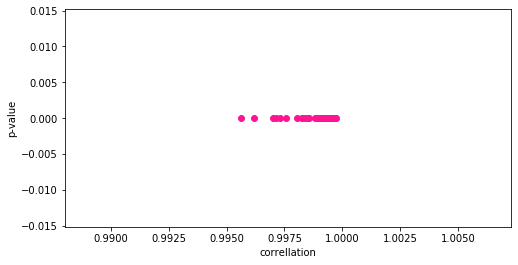

In [17]:
n = 50
step = len(main_table) // n
print('length of main table = ', len(main_table))

corr = np.zeros(n - 1)
p_value = np.zeros(n - 1)

for i in range(1, n, 1):
    corr[i - 1], p_value[i - 1] = pearsonr(np.sort(main_table['AMT_CREDIT'].astype('float')[(i - 1) * step : step * i]), 
                            np.sort(main_table['AMT_CREDIT'].astype('float')[i * step : step * (i + 1)]))
    print('correlation = %.4f' % corr[i - 1], '\t\t p-value = %.4f' % p_value[i - 1])
fig, ax = plt.subplots(figsize = (8, 4), facecolor = 'white')
ax.scatter(corr, p_value, c = 'deeppink')
ax.set_facecolor('white')
ax.set_ylabel('p-value')
ax.set_xlabel('correllation')
plt.show()

length of main table =  307511
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-value = 0.0000
correlation = 1.0000 		 p-

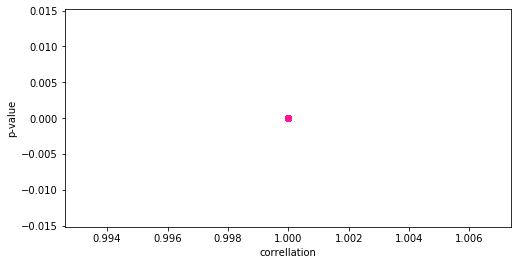

In [14]:
#checking on random arrays
n = 50
step = len(main_table) // n
print('length of main table = ', len(main_table))

corr = np.zeros(n - 1)
p_value = np.zeros(n - 1)

for i in range(1, n, 1):
    corr[i - 1], p_value[i - 1] = pearsonr(np.sort(np.linspace(1.0, 400.0, 1000)), np.sort(np.linspace(100.0 + i, 1100.0 + i, 1000)))
    print('correlation = %.4f' % corr[i - 1], '\t\t p-value = %.4f' % p_value[i - 1])
fig, ax = plt.subplots(figsize = (8, 4), facecolor = 'white')
ax.scatter(corr, p_value, c = 'deeppink')
ax.set_facecolor('white')
ax.set_ylabel('p-value')
ax.set_xlabel('correllation')
plt.show()

correlation = -0.0024 	 p-value = 0.6713
correlation = 0.0011 	 p-value = 0.8408
correlation = -0.0063 	 p-value = 0.2684
correlation = 0.0018 	 p-value = 0.7537
correlation = -0.0073 	 p-value = 0.1995
correlation = -0.0028 	 p-value = 0.6266
correlation = 0.0092 	 p-value = 0.1066
correlation = -0.0001 	 p-value = 0.9883
correlation = -0.0029 	 p-value = 0.6081


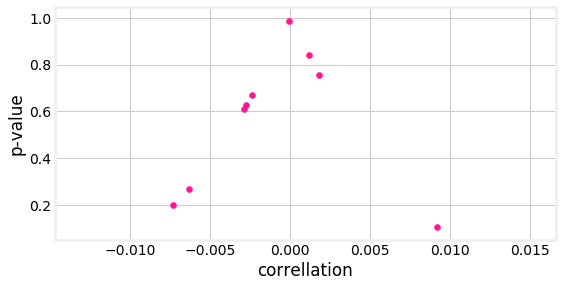

In [102]:
n = 10
step = len(main_table) // n

corr = np.zeros(n - 1)
p_value = np.zeros(n - 1)

for i in range(1, n, 1):
    corr[i - 1], p_value[i - 1] = pearsonr(main_table['AMT_INCOME_TOTAL'].astype('float')[ : step], 
                            main_table['AMT_INCOME_TOTAL'].astype('float')[i * step : step * (i + 1)])
    print('correlation = %.4f' % corr[i - 1], '\t p-value = %.4f' % p_value[i - 1])
fig, ax = plt.subplots(figsize = (8, 4), facecolor = 'white')
data = np.column_stack((corr, p_value))
ax.scatter(corr, p_value, c = 'deeppink')
ax.set_facecolor('white')
ax.set_ylabel('p-value')
ax.set_xlabel('correllation')
plt.show()

#### Хи-квадрат

chisquare = 366018210.4 	 p-value = 0.0000
chisquare = 360840609.3 	 p-value = 0.0000
chisquare = 404766840.9 	 p-value = 0.0000
chisquare = 40659838748.7 	 p-value = 0.0000
chisquare = 368101556.7 	 p-value = 0.0000
chisquare = 452887142.3 	 p-value = 0.0000
chisquare = 366703158.9 	 p-value = 0.0000
chisquare = 351375570.9 	 p-value = 0.0000
chisquare = 355754427.0 	 p-value = 0.0000
chisquare = 363917865.6 	 p-value = 0.0000
chisquare = 327470251.5 	 p-value = 0.0000
chisquare = 354600921.5 	 p-value = 0.0000
chisquare = 360271757.5 	 p-value = 0.0000
chisquare = 351407280.1 	 p-value = 0.0000
chisquare = 360563661.8 	 p-value = 0.0000
chisquare = 402641995.4 	 p-value = 0.0000
chisquare = 354330910.5 	 p-value = 0.0000
chisquare = 349832258.0 	 p-value = 0.0000
chisquare = 379558983.9 	 p-value = 0.0000
chisquare = 336133135.7 	 p-value = 0.0000
chisquare = 317225262.9 	 p-value = 0.0000
chisquare = 375891565.3 	 p-value = 0.0000
chisquare = 340562926.7 	 p-value = 0.0000
chisquare

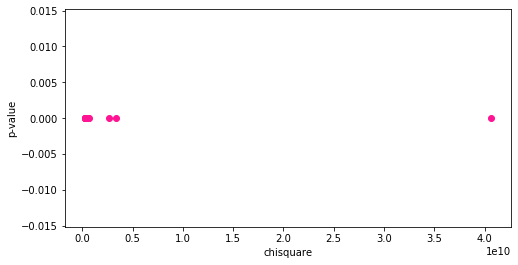

In [9]:
from scipy.stats import chisquare
n = 100
step = len(main_table) // n

chisqr = np.zeros(n - 1)
p_value = np.zeros(n - 1)

for i in range(1, n, 1):
    chisqr[i - 1], p_value[i - 1] = chisquare(f_obs = main_table['AMT_INCOME_TOTAL'].astype('float')[i * step : step * (i + 1)], 
                            f_exp = main_table['AMT_INCOME_TOTAL'].astype('float')[ : step])
    print('chisquare = %.1f' % chisqr[i - 1], '\t p-value = %.4f' % p_value[i - 1])
fig, ax = plt.subplots(figsize = (8, 4), facecolor = 'white')
ax.scatter(chisqr, p_value, c = 'deeppink')
ax.set_facecolor('white')
ax.set_ylabel('p-value')
ax.set_xlabel('chisquare')
plt.show()

In [122]:
from scipy.stats import chi2

print(chi2.ppf(0.95, 10))

18.307038053275146


In [118]:
def custom_chi2(X, Y):
    n1 = X.sum()
    n2 = Y.sum()
    summa = 0 
    for i in range(len(X)):
        summa += (n1 * Y[i] - n2 * X[i]) ** 2 / (X[i] + Y[i])
    return summa / (n1 * n2)

In [14]:
print(len(main_table))

307511


In [15]:
print(chi2.ppf(0.95, len(main_table) // 100 - 2))

3203.0776277032437


In [17]:
nsteps = 10
step = len(main_table) // nsteps
X = main_table['AMT_INCOME_TOTAL'].astype('float')[ : step]
Y = main_table['AMT_INCOME_TOTAL'].astype('float')[step : 5 * step]

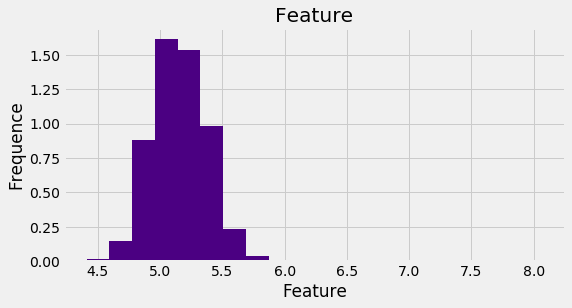

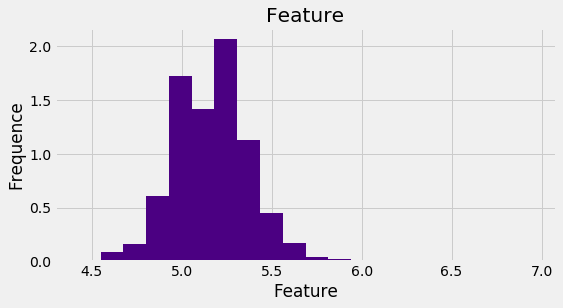

In [18]:
get_distribution(X, nbins = 20, log = True)
get_distribution(Y, nbins = 20, log = True)

In [142]:
q = 0.001

q0 = np.quantile(X, q)
q1 = np.quantile(X, 1 - q)
X = X[X > q0]
X = X[X < q1]

q2 = np.quantile(Y, q)
q3 = np.quantile(Y, 1 - q)
Y = Y[Y > q2]
Y = Y[Y < q3]

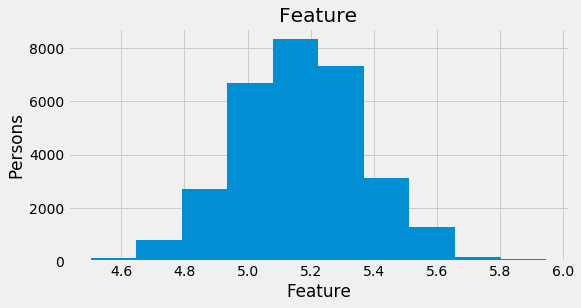

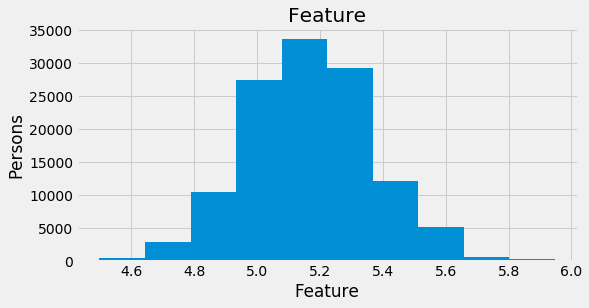

In [143]:
get_distribution(X, nbins = 10, log = True)
get_distribution(Y, nbins = 10, log = True)

In [144]:
print(X.min())
print(X.max())

31815.0
882000.0


In [6]:
qsteps = 10
bins = [np.quantile(X, q = i / qsteps) for i in range(qsteps + 1)]
X1 = np.histogram(X, bins = bins)[0]
Y1 = np.histogram(Y, bins = bins)[0]
print(X1)
print(Y1)

NameError: name 'X' is not defined

In [146]:
print(custom_chi2(X1, Y1))

10.040607555241397


In [165]:
print(chi2.cdf(30000.04, len(X) - 1))

0.0031626815566818227


In [9]:
def data_normalization(X, q = 0.001):
    q0 = np.quantile(X, q)
    q1 = np.quantile(X, 1 - q)
    X = X[X > q0]
    X = X[X < q1]
    return X

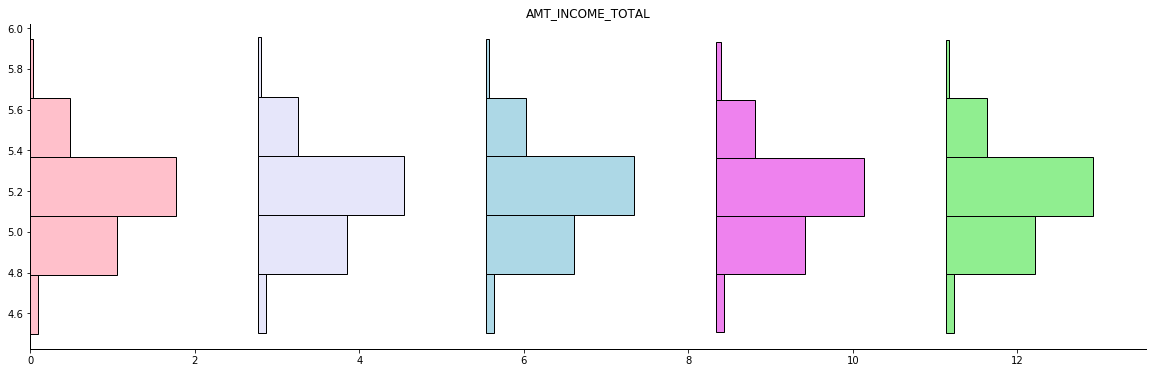

In [47]:
from scipy.stats import norm

nsteps = 5 #parameter
nbins = 5 #parameter
colors = ['pink',
          'lavender', 
          'lightblue', 
         'violet',
         'lightgreen',
         'plum', 
         'aquamarine',
         'lime',
         'indigo',
         'aquamarine',
         'pink',
          'lavender', 
          'lightblue', 
         'violet',
         'lightgreen',
         'plum', 
         'aquamarine',
         'lime',
         'indigo',
         'aquamarine']

def distribution_all(X, title = 'DISTRIBUTION', norm = False):
    #добавить вывод значений p-value на график 
    step = len(X) // nsteps
    fig, ax = plt.subplots(figsize = (20, 6), facecolor = 'w')
    bottom = 0
    for i in range(nsteps):
        if norm:
            data = data_normalization(X[step * i : step * (i + 1)])
        else: 
            data = X
        ax.set_title(title)
        shift = np.histogram(np.log10(data), density = True, bins = nbins)[0].max()
        ax.hist(np.log10(data), orientation = 'horizontal', bins = nbins, density = True, bottom = bottom,
                color = colors[i], edgecolor = 'black', linewidth = 1)
        ax.set_facecolor('w')
        ax.grid(False)
        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(1)
        for spine in ['right', 'top']:
            ax.spines[spine].set_color('white')
            ax.spines[spine].set_linewidth(1)
        bottom += shift + 1
    plt.show()
    
distribution_all(main_table['AMT_INCOME_TOTAL'].astype('float'), title = 'AMT_INCOME_TOTAL', norm = True)

In [15]:
def stability_check(X, Y, norm = True, qsteps = nbins):
    if norm:
        X = data_normalization(X)
        Y = data_normalization(Y)
    bins = np.array([np.quantile(X, q = i / qsteps) for i in range(qsteps + 1)])
    X1 = np.histogram(X, bins = bins)[0]
    print(X1)
    Y1 = np.histogram(Y, bins = bins)[0]
    print(Y1)
    print(len(X1))
    p_value = chi2.cdf(custom_chi2(X1, Y1), df = len(X1) - 1)
    return p_value

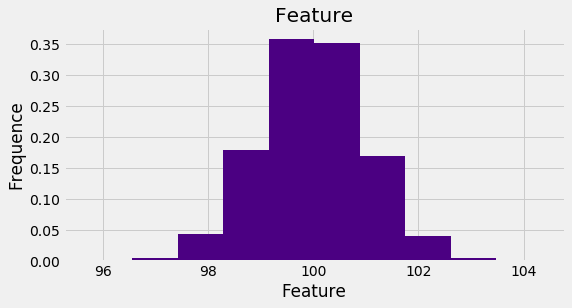

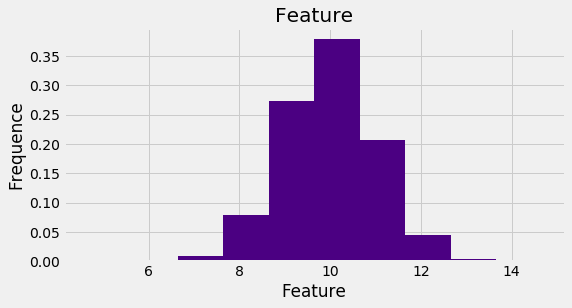

[10693 10693 10693 10693 10692 10693 10693 10693 10693 10692 10693 10693
 10693 10693]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14


NameError: name 'chi2' is not defined

In [84]:
import random
X = np.array([random.normalvariate(mu = 100, sigma = 1.0) for i in range(150000)])
get_distribution(X, nbins = 10)
Y = np.array([random.normalvariate(mu = 10, sigma = 1.0) for i in range(400000)])
get_distribution(Y, nbins = 10)
print(stability_check(X, Y, norm = True))

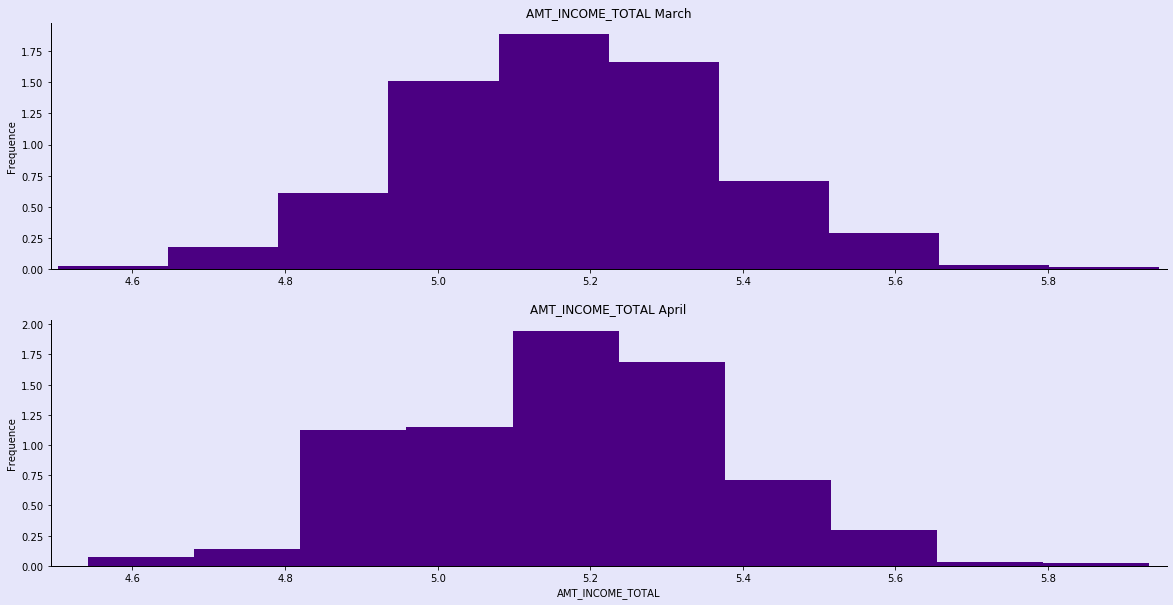

In [12]:
#vertical_lines
data = main_table['AMT_INCOME_TOTAL'].astype('float')
step = len(data) // nsteps
data0 = np.log10(data_normalization(data[0 * step : 1 * step]))
data1 = np.log10(data_normalization(data[9 * step : 10 * step]))
bins = np.array([np.quantile(data0, q = i / nbins) for i in range(nbins + 1)])
fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize = (20, 10), facecolor = 'lavender')
for i in range(2):
    ax[i].grid(False)
    ax[i].set_facecolor('lavender')
    ax[i].set_xlim([data0.min() - 0.01, data0.max() + 0.01])
    for spine in ['left', 'bottom']:
        ax[i].spines[spine].set_color('black')
        ax[i].spines[spine].set_linewidth(1)
    for spine in ['right', 'top']:
        ax[i].spines[spine].set_color('lavender')
        ax[i].spines[spine].set_linewidth(1)
    #for line in bins:
    #    ax[i].vlines(line, 0, 2.5, linewidth = 2, color = 'r', linestyle = '--')
ax[0].set_title('AMT_INCOME_TOTAL March')
ax[0].set_ylabel('Frequence')
ax[0].hist(data0, bins = nbins, color = 'indigo', density = True)
ax[1].set_title('AMT_INCOME_TOTAL April')
ax[1].set_ylabel('Frequence')
ax[1].set_xlabel('AMT_INCOME_TOTAL')
ax[1].hist(data1, bins = nbins, color = 'indigo', density = True)
plt.show()

[23526  6261   731   132    41]
[23658  6146   718   133    43]
[26043  4140   392    76    30]
[23599  6161   763   119    38]
[23650  6117   753   131    45]


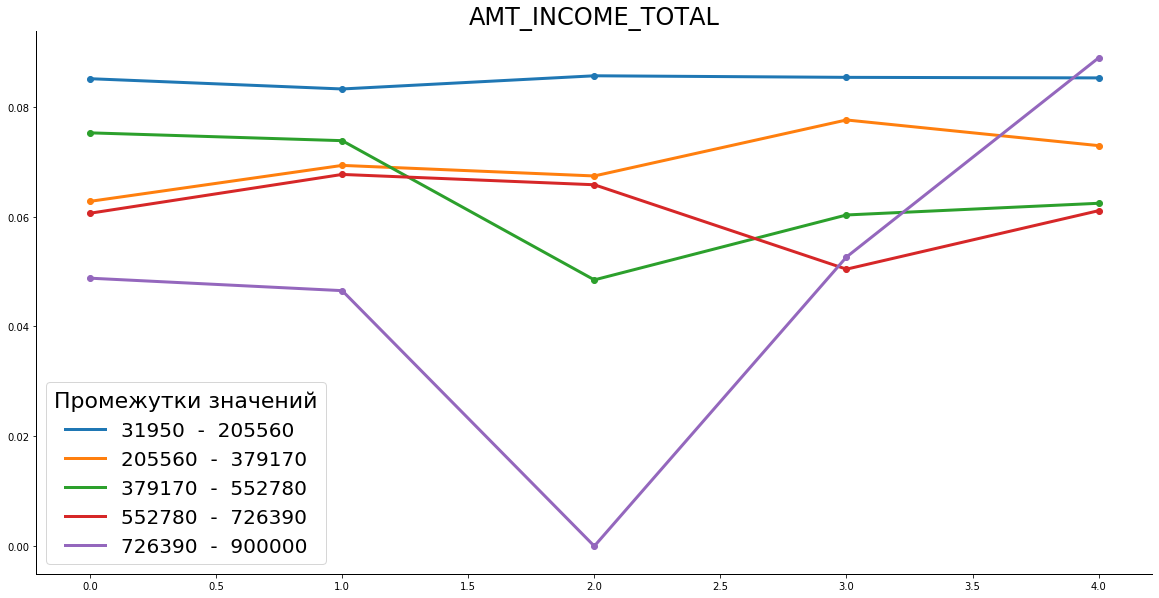

In [76]:
rates = np.zeros((nsteps, nbins))
for i in range(nsteps):
    data = main_table[i * step : (i + 1) * step]['AMT_INCOME_TOTAL'].astype('float')
    q0 = np.quantile(data, q = 0.001)
    q1 = np.quantile(data, q = 0.999)                                                                    
    target = main_table[i * step : (i + 1) * step]['TARGET'].astype('float')
    target = target[q0 < data]
    data = data[q0 < data]
    target = target[data <= q1]
    data = data[data <= q1]
    histogram = np.histogram(data, bins = nbins)
    print(histogram[0])
    for j in range(nbins):
        if j == 0:
            target_j = target[(data >= histogram[1][j]) & (data <= histogram[1][j + 1])]
        else:
            target_j = target[(data > histogram[1][j]) & (data <= histogram[1][j + 1])]
        rates[i][j] = target_j.sum() / histogram[0][j]
fig, ax = plt.subplots(figsize = (20, 10), facecolor = 'white')
ax.grid(False)
ax.set_facecolor('white')
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)
for spine in ['right', 'top']:
    ax.spines[spine].set_color('white')
    ax.spines[spine].set_linewidth(1)

x = [i for i in range(nsteps)]    
for j in range(nbins):
    ax.plot(x, rates[:, j], linewidth = 3, label = '%d  -  %d' %(histogram[1][j], histogram[1][j + 1]))
    ax.set_title('AMT_INCOME_TOTAL', fontsize = 24)
    ax.scatter(x, rates[:, j])
plt.legend(fontsize = 20, title = 'Промежутки значений', title_fontsize = 22)
plt.show()